In [12]:
!pip install git+https://github.com/earthlab/earthpy@apppears

  Cloning https://github.com/earthlab/earthpy (to revision apppears) to /tmp/pip-req-build-4lu7_uuz
  Running command git clone --filter=blob:none --quiet https://github.com/earthlab/earthpy /tmp/pip-req-build-4lu7_uuz
  Running command git checkout -b apppears --track origin/apppears
  Switched to a new branch 'apppears'
  Branch 'apppears' set up to track remote branch 'apppears' from 'origin'.
  Resolved https://github.com/earthlab/earthpy to commit 7241165d59af510d62bba312e48c7f513bc9dc05
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [13]:
!conda install -y earthaccess

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [14]:
import getpass
import json
import os
import pathlib
from glob import glob

import earthpy.appeears as eaapp
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr
import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import requests
import itertools
import folium
import earthaccess
import earthpy.plot as ep


In [15]:
data_dir = os.path.join(
    pathlib.Path.home(), 'grizzly-creek')
# Make the data directory
os.makedirs(data_dir, exist_ok=True)

In [16]:
# Download the Grizzly Creek fire boundary

url = (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/WFIGS_Interagency_Perimeters/FeatureServer/0/query"
    "?where=attr_IncidentName%20%3D%20%27GRIZZLY%20CREEK%27"
    "&outFields=*&outSR=4326&f=json")
print(url)
bounds_gdf= gpd.read_file(url)

https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters/FeatureServer/0/query?where=attr_IncidentName%20%3D%20%27GRIZZLY%20CREEK%27&outFields=*&outSR=4326&f=json


/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime withou

In [17]:
bounds_gdf = bounds_gdf.loc[[1]]
bounds_gdf

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,attr_IncidentComplexityLevel,geometry
1,14453,13272,Grizzly Creek,Wildfire Final Fire Perimeter,Infrared Image,32431.62,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-04 00:37:00+00:00,{BC150C8C-D9C8-4C14-8725-2B84D7695302},...,FODR,None,None,None,{E4E21DCE-C8EE-4133-B9F7-5CA2E5FBF79C},c9133643-c537-4030-a059-04d80c6c3a96,0.013763,1.34652,None,"MULTIPOLYGON (((-107.19151 39.66880, -107.1914..."


<class 'geopandas.geodataframe.GeoDataFrame'>


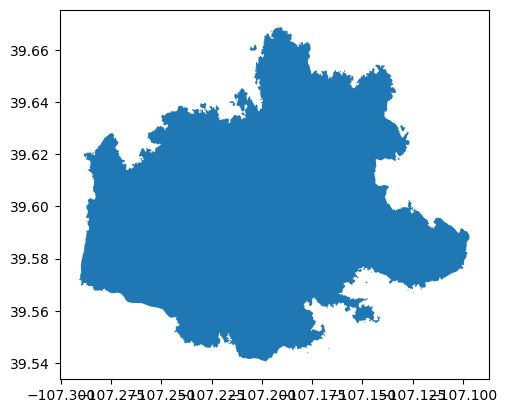

In [18]:
bounds_gdf.plot()
print(type(bounds_gdf))

In [19]:
def fetch_stac_server(query):
    '''
    Queries the stac-server (STAC) backend.
    This function handles pagination.
    query is a python dictionary to pass as json to the request.
    '''
    headers = {
        "Content-Type": "application/json",
        "Accept-Encoding": "gzip",
        "Accept": "application/geo+json",
    }

    url = f"https://landsatlook.usgs.gov/stac-server/search"
    data = requests.post(url, headers=headers, json=query).json()
    error = data.get("message", "")
    if error:
        raise Exception(f"STAC-Server failed and returned: {error}")

    context = data.get("context", {})
    if not context.get("matched"):
        return []
    print(context)

    features = data["features"]
    if data["links"]:
        query["page"] += 1
        query["limit"] = context["limit"]

        features = list(itertools.chain(features, fetch_stac_server(query)))

    return features

query = {"bbox":[-109.6875,38.82259097617712,-106.875,40.97989806962013],
         "collections":["landsat-c2l2-sr"],
         "query":{"eo:cloud_cover":{"lte":11},
                  "platform":{"in":["LANDSAT_8"]},
                  "landsat:collection_category":{"in":["T1","T2","RT"]}},
                  "datetime":"2020-12-15T00:00:00.000Z/2021-01-15T23:59:59.999Z",
                  "page":1,"limit":100}

features = fetch_stac_server(query)

{'limit': 100, 'matched': 13, 'returned': 13}
{'limit': 100, 'matched': 13, 'returned': 0}


In [20]:
features 

[{'type': 'Feature',
  'stac_version': '1.0.0',
  'stac_extensions': ['https://landsat.usgs.gov/stac/landsat-extension/v1.1.1/schema.json',
   'https://stac-extensions.github.io/view/v1.0.0/schema.json',
   'https://stac-extensions.github.io/projection/v1.0.0/schema.json',
   'https://stac-extensions.github.io/eo/v1.0.0/schema.json',
   'https://stac-extensions.github.io/alternate-assets/v1.1.0/schema.json',
   'https://stac-extensions.github.io/storage/v1.0.0/schema.json',
   'https://stac-extensions.github.io/file/v1.0.0/schema.json',
   'https://stac-extensions.github.io/accuracy/v1.0.0/schema.json',
   'https://stac-extensions.github.io/card4l/v0.1.0/optical/schema.json',
   'https://stac-extensions.github.io/classification/v1.0.0/schema.json'],
  'id': 'LC08_L2SP_037033_20210115_20210308_02_T1_SR',
  'description': 'Landsat Collection 2 Level-2 Surface Reflectance Product',
  'bbox': [-112.14856731668134,
   37.84375957493384,
   -109.53701497128573,
   39.95308919988823],
  'geom

In [21]:
auth = earthaccess.login()

Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}


In [22]:
bounds_gdf.total_bounds

array([-107.29087429,   39.54018701, -107.09664928,   39.6689729 ])

In [23]:
results = earthaccess.search_data(
    short_name = "HLSL30", 
    temporal = ("2021-06", "2021-07"),
    bounding_box = tuple(bounds_gdf.total_bounds)
)


Granules found: 12


In [24]:
files = earthaccess.download(results, "./Data/landsat")

'NoneType' object has no attribute 'get'
You must call earthaccess.login() before you can download data


In [25]:
band_name_list = ["B04", "B03", "B02"]

In [26]:
NIR_data_list = []
for band_name in band_name_list:
    print (band_name)
    NIR_path = f"/workspaces/MSUGrizzlyCreek2020Fire/notebooks/Data/landsat/HLS.L30.T13SBD.2021161T174928.v2.0.{band_name}.tif"
    print (NIR_path)
    NIR_data = rxr.open_rasterio(NIR_path, masked = True).squeeze()
    NIR_data_list.append( NIR_data.rio.clip_box(*bounds_gdf.to_crs(NIR_data.rio.crs).total_bounds))
NIR_data_list


B04
/workspaces/MSUGrizzlyCreek2020Fire/notebooks/Data/landsat/HLS.L30.T13SBD.2021161T174928.v2.0.B04.tif


B03
/workspaces/MSUGrizzlyCreek2020Fire/notebooks/Data/landsat/HLS.L30.T13SBD.2021161T174928.v2.0.B03.tif
B02
/workspaces/MSUGrizzlyCreek2020Fire/notebooks/Data/landsat/HLS.L30.T13SBD.2021161T174928.v2.0.B02.tif


[<xarray.DataArray (y: 477, x: 219)>
 [104463 values with dtype=float32]
 Coordinates:
     band         int64 1
   * x            (x) float64 3.032e+05 3.033e+05 ... 3.097e+05 3.098e+05
   * y            (y) float64 4.393e+06 4.393e+06 ... 4.379e+06 4.379e+06
     spatial_ref  int64 0
 Attributes: (12/35)
     ACCODE:                    Lasrc; Lasrc
     add_offset:                0.0
     AREA_OR_POINT:             Area
     arop_ave_xshift(meters):   0, 0
     arop_ave_yshift(meters):   0, 0
     arop_ncp:                  0, 0
     ...                        ...
     SPATIAL_RESOLUTION:        30
     TIRS_SSM_MODEL:            FINAL; FINAL
     TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
     ULX:                       199980
     ULY:                       4400040
     USGS_SOFTWARE:             LPGS_15.5.0,
 <xarray.DataArray (y: 477, x: 219)>
 [104463 values with dtype=float32]
 Coordinates:
     band         int64 1
   * x            (x) float64 3.032e+05 3.033e+05 ... 3.0

In [27]:
RGB_data = xr.concat(NIR_data_list, dim="layer")
RGB_data = RGB_data.transpose("layer","x", "y")

In [28]:
RGB_data

<xarray.DataArray (layer: 3, x: 219, y: 477)>
array([[[358., 418., 456., ..., 280., 297., 359.],
        [497., 459., 444., ..., 341., 420., 437.],
        [379., 302., 386., ..., 375., 408., 473.],
        ...,
        [914., 905., 733., ..., 187., 206., 226.],
        [881., 926., 903., ..., 247., 235., 261.],
        [834., 856., 899., ..., 282., 288., 283.]],

       [[336., 377., 409., ..., 425., 439., 487.],
        [430., 420., 399., ..., 468., 516., 541.],
        [356., 297., 368., ..., 505., 529., 559.],
        ...,
        [772., 768., 666., ..., 322., 320., 369.],
        [747., 772., 752., ..., 387., 378., 384.],
        [745., 731., 744., ..., 421., 419., 385.]],

       [[118., 168., 194., ..., 182., 192., 222.],
        [209., 199., 209., ..., 216., 256., 261.],
        [149., 132., 171., ..., 233., 242., 273.],
        ...,
        [409., 406., 341., ...,  98., 106., 119.],
        [408., 413., 404., ..., 125., 122., 129.],
        [407., 401., 416., ..., 150., 146., 139.]]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.032e+05 3.033e+05 ... 3.097e+05 3.098e+05
  * y            (y) float64 4.393e+06 4.393e+06 ... 4.379e+06 4.379e+06
    spatial_ref  int64 0
Dimensions without coordinates: layer
Attributes: (12/35)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    ...                        ...
    SPATIAL_RESOLUTION:        30
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       199980
    ULY:                       4400040
    USGS_SOFTWARE:             LPGS_15.5.0

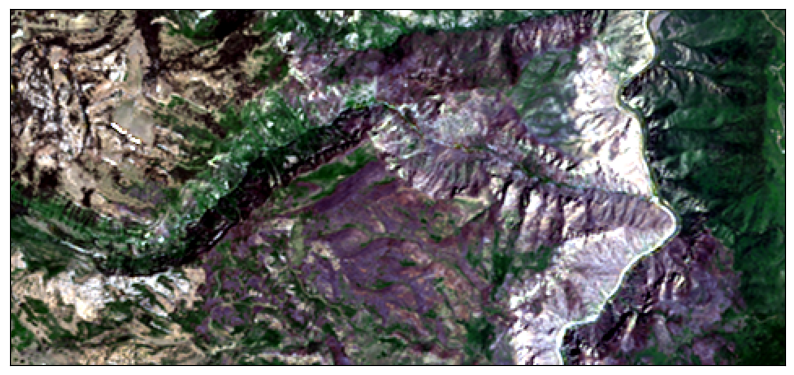

<Axes: >

In [29]:
ep.plot_rgb(RGB_data.values,stretch=True)

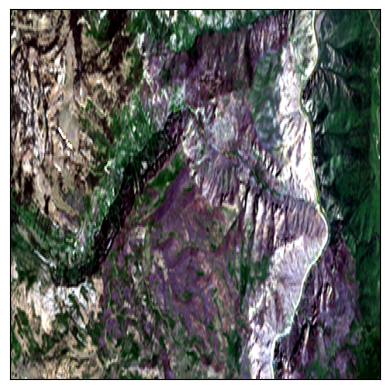

In [30]:
# Plot uncropped array
f, ax = plt.subplots()

ep.plot_rgb(RGB_data.values,stretch=True,
extent=bounds_gdf.to_crs(NIR_data.rio.crs).total_bounds, 
ax=ax)
            

bounds_gdf.to_crs(RGB_data.rio.crs).plot(ax=ax)

plt.show()

<Axes: >

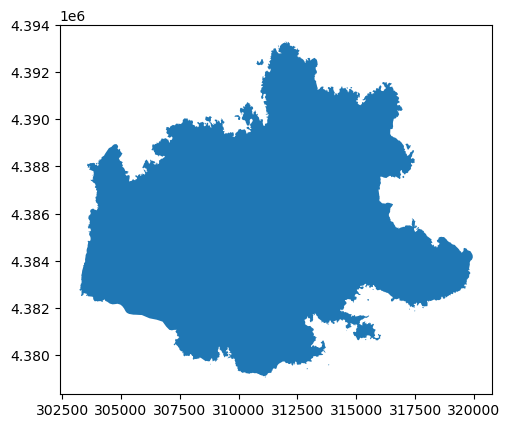

In [31]:
bounds_gdf.to_crs(RGB_data.rio.crs).plot()

In [46]:
RGB_data.hvplot.rgb(
        x='x', y='y', bands='layer',
        data_aspect=1,
        xaxis=None, yaxis=None, 
        title='Grizzly Creek Fire',
        rasterize=True)

DataError: Key dimension values and value array R shapes do not match. Expected shape (477, 219), actual shape: (219, 477)

GridInterface expects gridded data, for more information on supported datatypes see http://holoviews.org/user_guide/Gridded_Datasets.html

In [ ]:
NIR_data

<xarray.DataArray (y: 477, x: 219)>
[104463 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 3.032e+05 3.033e+05 ... 3.097e+05 3.098e+05
  * y            (y) float64 4.393e+06 4.393e+06 ... 4.379e+06 4.379e+06
    spatial_ref  int64 0
Attributes: (12/35)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    ...                        ...
    SPATIAL_RESOLUTION:        30
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       199980
    ULY:                       4400040
    USGS_SOFTWARE:             LPGS_15.5.0

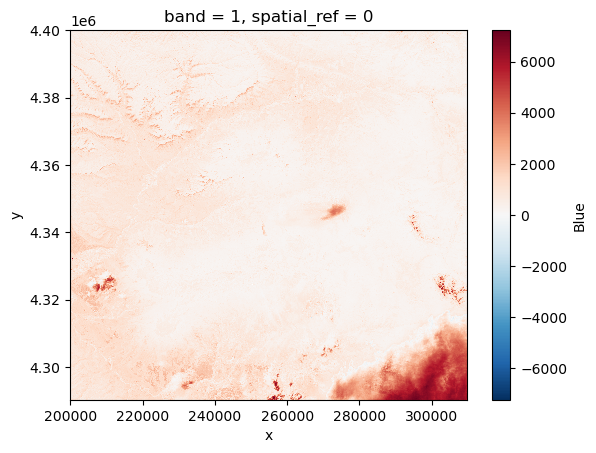

In [34]:
NIR_data.plot()

In [35]:
data_url = ("https://github.com/cu-esiil-edu/MSUGrizzlyCreek2020Fire/"
            "releases/download/data-release/"
            "co3957210726620200810_20200809_20210710_"
            "ravg_data.zip")
data_path = et.data.get_data(url=data_url)
data_path

'/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data'

In [36]:
burn_severity_path = glob(os.path.join(data_path, "*.tif"))
burn_severity_path

['/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_rdnbr.tif',
 '/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_rdnbr_ba.tif',
 '/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_rdnbr_cbi4.tif',
 '/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_rdnbr_ba4.tif',
 '/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_dnbr.tif',
 '/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_rdnbr_cc.tif',
 '/home/jovyan/earth-analytics/data/earthpy-downlo

In [37]:
burn_severity_path = glob(os.path.join(data_path, "*.xlsx"))
burn_severity_path

['/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_ravg_table_BA.xlsx']

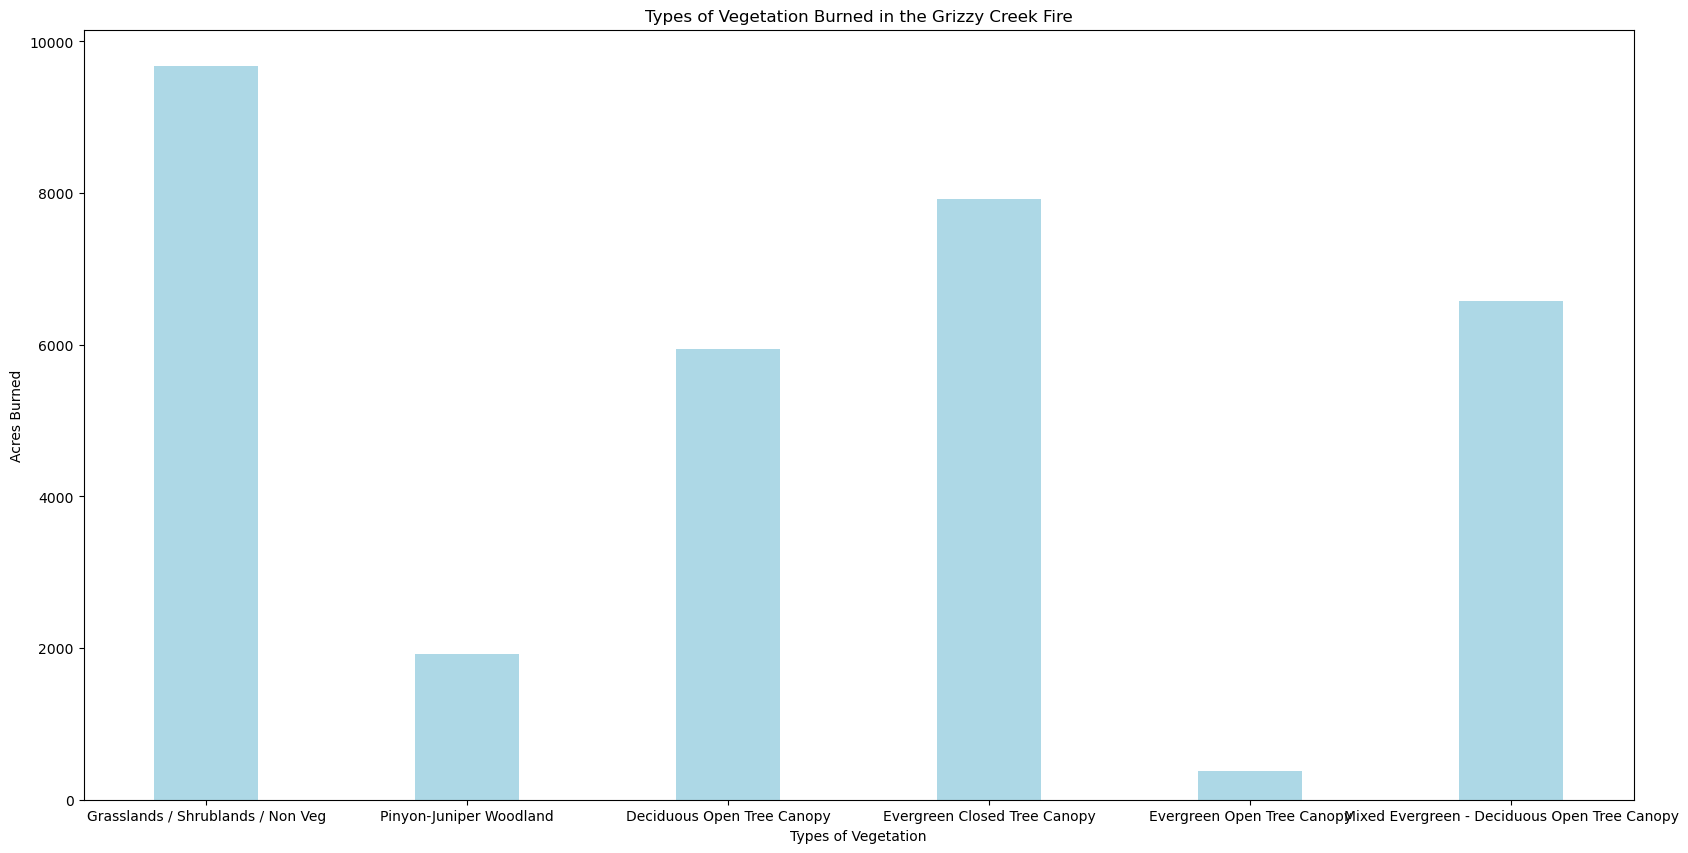

In [41]:
# creating the dataset
data = {'Grasslands / Shrublands / Non Veg':9671, 
        'Pinyon-Juniper Woodland':1928, 
        'Deciduous Open Tree Canopy':5948, 
        'Evergreen Closed Tree Canopy':7922,
        'Evergreen Open Tree Canopy':377,
        'Mixed Evergreen - Deciduous Open Tree Canopy': 6576,}
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (20, 10))

# creating the bar plot
plt.bar(courses, values, color ='lightblue', 
        width = 0.4)

plt.xlabel("Types of Vegetation")
plt.ylabel("Acres Burned")
plt.title("Types of Vegetation Burned in the Grizzy Creek Fire")
plt.show()

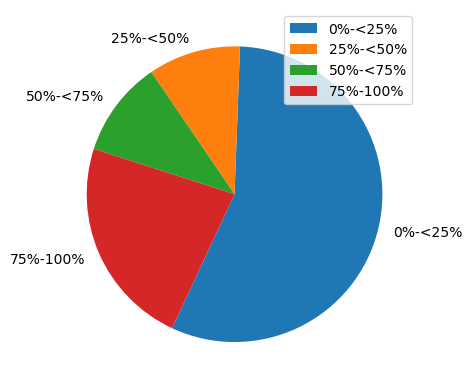

In [39]:
y = np.array([4562, 819, 851, 1863])
mylabels = ["0%-<25%", "25%-<50%", "50%-<75%", "75%-100%"]

plt.pie(y, labels = mylabels, startangle = -115)
plt.legend()
plt.show() 

In [42]:
burn_severity_path = glob(os.path.join(data_path, "*_dnbr.tif"))[0]
burn_severity_path

'/home/jovyan/earth-analytics/data/earthpy-downloads/co3957210726620200810_20200809_20210710_ravg_data/co3957210726620200810_20200809_20210710_dnbr.tif'

In [43]:
grizzly_creek_burn_severity = rxr.open_rasterio(burn_severity_path, masked=True).squeeze()

grizzly_creek_burn_severity = grizzly_creek_burn_severity.where(grizzly_creek_burn_severity>-2000)
grizzly_creek_burn_severity

<xarray.DataArray (y: 674, x: 756)>
array([[ nan,  nan,  nan, ...,  26.,  14., -20.],
       [ nan,  nan,  nan, ..., -23., -10., -15.],
       [ nan,  nan,  nan, ...,  18., -25., -42.],
       ...,
       [ 27.,  43.,  29., ..., -82., -47., -37.],
       [ 30.,  54.,  38., ..., -35., -58., -95.],
       [ 48.,  75.,  48., ..., -44., -81., -36.]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -9.619e+05 -9.619e+05 ... -9.393e+05 -9.393e+05
  * y            (y) float64 1.909e+06 1.909e+06 ... 1.889e+06 1.889e+06
    spatial_ref  int64 0
Attributes: (12/23)
    AREA_OR_POINT:              Area
    TIFFTAG_RESOLUTIONUNIT:     1 (unitless)
    TIFFTAG_SOFTWARE:           IMAGINE TIFF Support\nCopyright 1991 - 1999 b...
    TIFFTAG_XRESOLUTION:        1
    TIFFTAG_YRESOLUTION:        1
    LAYER_TYPE:                 athematic
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          213.02880480086
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

In [44]:
grizzly_creek_burn_severity.rio.crs

CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

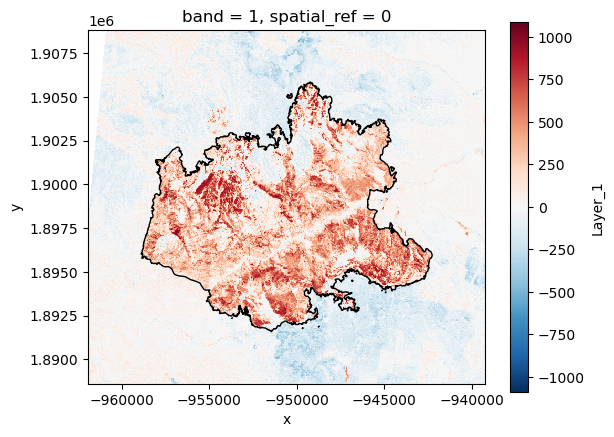

In [45]:
fig, ax = plt.subplots(1, 1)
grizzly_creek_burn_severity.plot(ax=ax)
bounds_gdf.to_crs(grizzly_creek_burn_severity.rio.crs).plot(ax=ax, facecolor="none")